In [441]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import f_oneway
from sklearn.cross_validation import train_test_split
from sklearn import feature_selection, metrics, tree
from sklearn.neighbors import KNeighborsClassifier as KNN

from IPython.html.widgets import interact, fixed

%matplotlib inline
sns.set_context(context = 'talk')

D:\Anaconda\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


#### Introduction And Data Processing:

Dataset:

* 4 columns `B`, `G`, `R` and `Skin` (the last is the categorical one).
* 245057 observations:
    + 50859 is skin
    + 194198 is non-skin

In [57]:
dt = pd.read_csv('Skin_NonSkin.csv', sep = '\t', names = ['B', 'G', 'R', 'Skin'])
print(len(dt.index))
dt.head()

245057


,B,G,R,Skin
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1


In [58]:
dt.groupby(by = 'Skin').count().iloc[:,0]

Skin
1     50859
2    194198
Name: B, dtype: int64

`1` is skin and `2` is non-skin.

Reorganize the dataset as:

* columns reordered as R, G, B and Skin
* Add values of R, G and B normalized by 255 (easier for color manipulations)
* Skin values changed to:
    + `0` is non-skin
    + `1` is skin

In [92]:
dt.loc[dt.loc[:,'Skin'] == 2, 'Skin'] = 0
dt['R_norm'] = dt['R'] / 255.0
dt['G_norm'] = dt['G'] / 255.0
dt['B_norm'] = dt['B'] / 255.0
dt = dt[['R', 'G', 'B', 'R_norm', 'G_norm', 'B_norm', 'Skin']]
dt.head(10)

,R,G,B,R_norm,G_norm,B_norm,Skin
0,123,85,74,0.482353,0.333333,0.290196,1
1,122,84,73,0.478431,0.329412,0.286275,1
2,121,83,72,0.474510,0.325490,0.282353,1
3,119,81,70,0.466667,0.317647,0.274510,1
4,119,81,70,0.466667,0.317647,0.274510,1
5,118,80,69,0.462745,0.313725,0.270588,1
6,119,81,70,0.466667,0.317647,0.274510,1
7,119,81,70,0.466667,0.317647,0.274510,1
8,125,87,76,0.490196,0.341176,0.298039,1
9,125,87,76,0.490196,0.341176,0.298039,1


Make a `pairplot` with the different features:

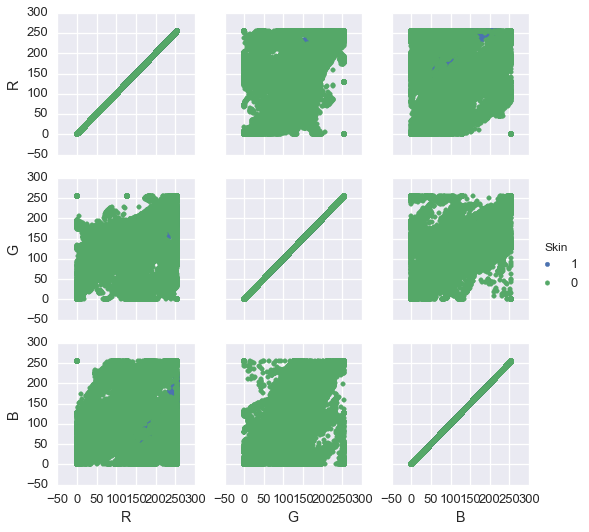

In [290]:
def displayPairPlot():
    g = sns.PairGrid(dt, hue = 'Skin' , vars = ['R', 'G', 'B'], aspect = 1, size = 2.5)
    g.map(plt.scatter)
    g.add_legend()

displayPairPlot()

Hard to distinguish something; it's like the skin is clouded by the non-skin. Let's try to check this is 3D.

But first, use a `ColorBar` to display the different nuances of skins (the axis ticks are arbitrary)

*(NOTA: the parameters in the `add_axes()` function are respectively: left, bottom, wide, height)*

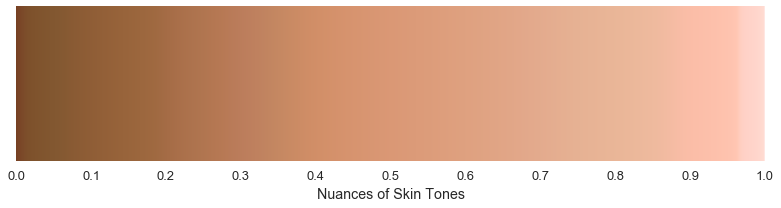

In [143]:
def displaySkinTones():
    colors_to_map = dt[dt['Skin'] == 1].loc[:,'R_norm':'B_norm'].values
    colors_to_map.sort(axis = 0)
    cmap = mpl.colors.ListedColormap(colors_to_map)
    norm = mpl.colors.Normalize(vmin = 0.0, vmax = 1.0)
    g = mpl.colorbar.ColorbarBase(plt.figure().add_axes([0.0, 1.0, 1.0, 0.3]), norm = norm,
                                  cmap = cmap, orientation = 'horizontal')
    g.set_label('Nuances of Skin Tones');
    
displaySkinTones()

Try to display the whole dataset in a 3D plot, each point being of the actual color:

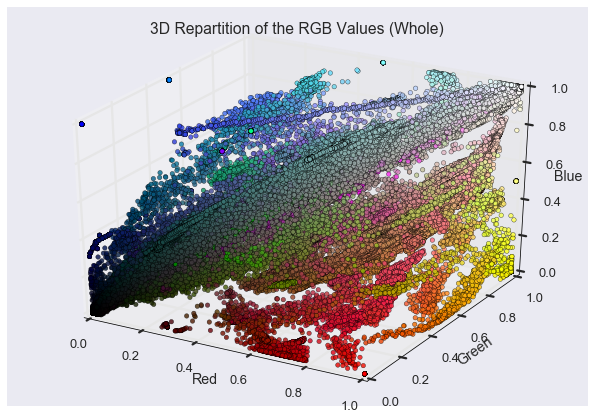

In [176]:
def displayScatter3DWhole():
    vals = dt.loc[:,'R_norm':'B_norm']
    colors = vals.values
    ax = plt.figure().add_subplot(111, projection = '3d')
    ax.scatter(vals['R_norm'].values,
               vals['G_norm'].values,
               vals['B_norm'].values,
               alpha = 0.8, c = colors);
    ax.set_title('3D Repartition of the RGB Values (Whole)')
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_zlim(0.0, 1.0);

displayScatter3DWhole()

Hard to distinguish the skin and non-skin; try the same thing on 2 different 3D plots:

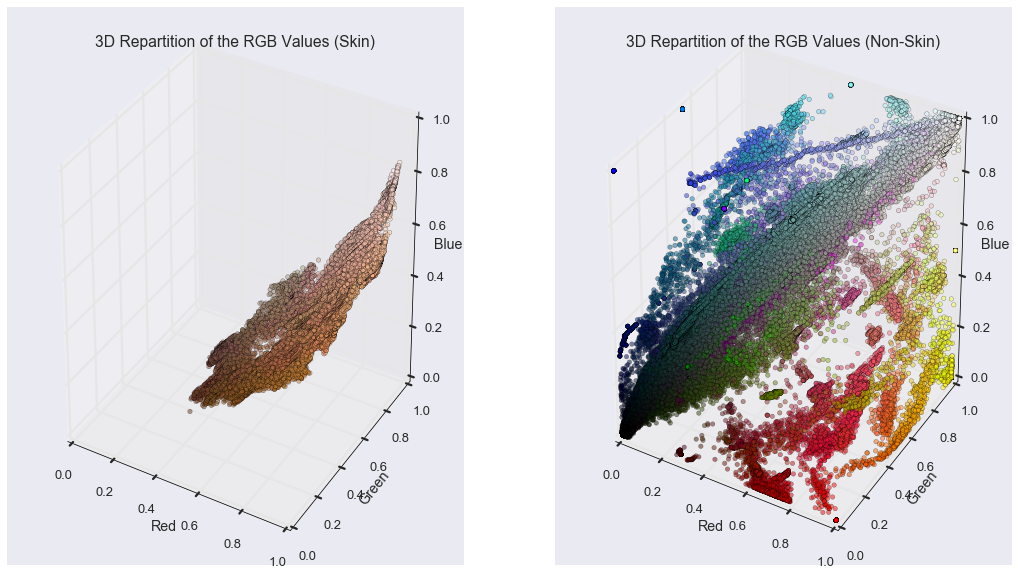

In [251]:
def displayScatter3D():
    dt_skin = dt[dt['Skin'] == 1].loc[:,'R_norm':'B_norm']
    dt_nskin = dt[dt['Skin'] == 0].loc[:,'R_norm':'B_norm']
    colors_skin = dt_skin.values
    colors_nskin = dt_nskin.values
    fig = plt.figure(1, figsize = (18, 10))
    ax1 = fig.add_subplot(121, projection = '3d')
    ax1.scatter(dt_skin['R_norm'].values,
                dt_skin['G_norm'].values,
                dt_skin['B_norm'].values,
                alpha = 0.5, c = colors_skin);
    ax1.set_title('3D Repartition of the RGB Values (Skin)')
    ax1.set_xlabel('Red')
    ax1.set_ylabel('Green')
    ax1.set_zlabel('Blue')
    ax1.set_xlim(0.0, 1.0)
    ax1.set_ylim(0.0, 1.0)
    ax1.set_zlim(0.0, 1.0);
    
    ax2 = fig.add_subplot(122, projection = '3d')
    ax2.scatter(dt_nskin['R_norm'].values,
                dt_nskin['G_norm'].values,
                dt_nskin['B_norm'].values,
                alpha = 0.5, c = colors_nskin)
    ax2.set_title('3D Repartition of the RGB Values (Non-Skin)')
    ax2.set_xlabel('Red')
    ax2.set_ylabel('Green')
    ax2.set_zlabel('Blue')
    ax2.set_xlim(0.0, 1.0)
    ax2.set_ylim(0.0, 1.0)
    ax2.set_zlim(0.0, 1.0);

displayScatter3D()

Looks like the skin tones really create a tight cluster, with little variations.

Some numerical computations to confirm:

In [198]:
def displayMeanStd():
    dat = dt[dt['Skin'] == 1].loc[:, 'R_norm':'B_norm']
    for col in dat.columns:
        mean = dat[col].mean()
        std = dat[col].std()
        print('For primary color {} => mean is {:.2f} / standard deviation is {:.2f}'.format(col, mean, std))

displayMeanStd()

For primary color R_norm => mean is 0.80 / standard deviation is 0.15
For primary color G_norm => mean is 0.57 / standard deviation is 0.14
For primary color B_norm => mean is 0.45 / standard deviation is 0.16


The variation is indeed small (at least not that big), with the biggest one being the `Blue` color. Except for the `Red` color, the values are more or less centered around `0.5`.

#### Cross Validation 1 (with a shotgun):

Take all the 3 features and try to find the best k with a bunch of iterations. In order to keep a reasonnable running time, the maximum number of neighbors will be limited to `100`, with an increment of `2`. So basically, it looks like this:

$$S_{neighbors}~=~\left[ 1, 3, 5, 7, \dots, 99 \right]$$

Still a bit long to run though... That's why we can use the `n_jobs` argument to parallelize this and speed-up a bit.

In [350]:
def crossValidationManiac(n = 100):
    X = dt.ix[:,'R':'B']
    y = dt.ix[:, 'Skin']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)
    n_neigh = range(1, n, 2)
    scores = list()
    for n in n_neigh:
        clf_model = KNN(n, n_jobs = 4)
        clf_model.fit(X_train, y_train)
        scores.append(clf_model.score(X_test, y_test))
    plt.figure(figsize=(20,8))
    plt.plot(n_neigh, scores, linewidth=3.0);
    plt.xticks(n_neigh)

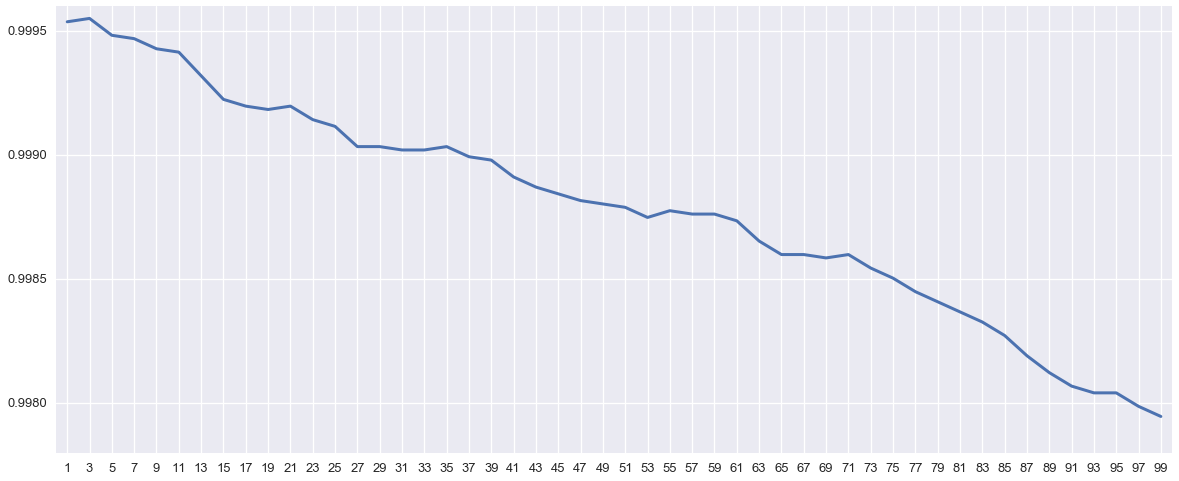

In [351]:
crossValidationManiac()

Alright, it looks like high values of `k` are not necessary; we may get satisfying results by limiting `k` to 40:

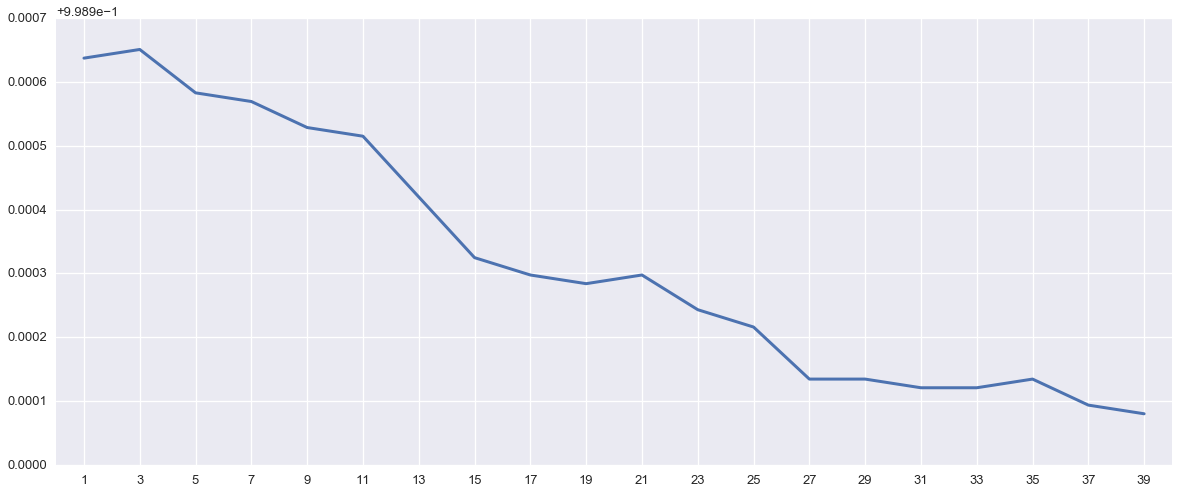

In [352]:
crossValidationManiac(40)

The scores are bound within the intervall $\left[ 0.9989;0.9996 \right]$ and the best score is for `k = 3`.

#### Cross Validation 2 (with a rocket launcher):

Now, let's see what is the most reliable k over some iterations (go grab a coffee, it's gonna take a while).

*(NOTA: DO NOT SET `random_state` PARAMETER OR THE RESULTS WILL BE THE SAME OVER EACH ITERATION)*

In [353]:
def crossValidationBerserk(itr = 5):
    X = dt.ix[:,'R':'B']
    y = dt.ix[:, 'Skin']
    n_neigh = range(1, 40, 2)
    scores = defaultdict(list)
    for i in range(itr):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
        for n in n_neigh:
            clf_model = KNN(n, n_jobs = 4)
            clf_model.fit(X_train, y_train)
            scores[n].append(clf_model.score(X_test, y_test))
    scores = [np.mean(scores[k]) for k in scores]
    plt.figure(figsize = (20, 8))
    plt.plot(n_neigh, scores, linewidth=3.0);
    plt.xticks(n_neigh)

In [354]:
crossValidationBerserk(500)

KeyboardInterrupt: 

* `100`  iterations $\Rightarrow$ `k = 3` (score > 0.995)
* `500`  iterations $\Rightarrow$ `k = ` (score > )
* `1000` iterations $\Rightarrow$ __WAY__ too much time...

#### Model Simplification

In [283]:
def checkFeatures():
    X = dt.ix[:,'R':'B']
    y = dt.ix[:, 'Skin']
    F1 = feature_selection.f_classif(X, y)[0]
    F2 = feature_selection.f_classif(X.ix[:, 'G':'B'], y)[0]
    fig = plt.figure(1, figsize = (12, 8))
    
    ax1 = fig.add_subplot(121)
    ax1.bar(np.arange(3), F1, width = 0.70, tick_label = ('Red', 'Green', 'Blue'), align = 'center')
    
    ax2 = fig.add_subplot(122)
    ax2.bar(np.arange(2), F2, width = 0.35, tick_label = ('Green', 'Blue'), align = 'center')

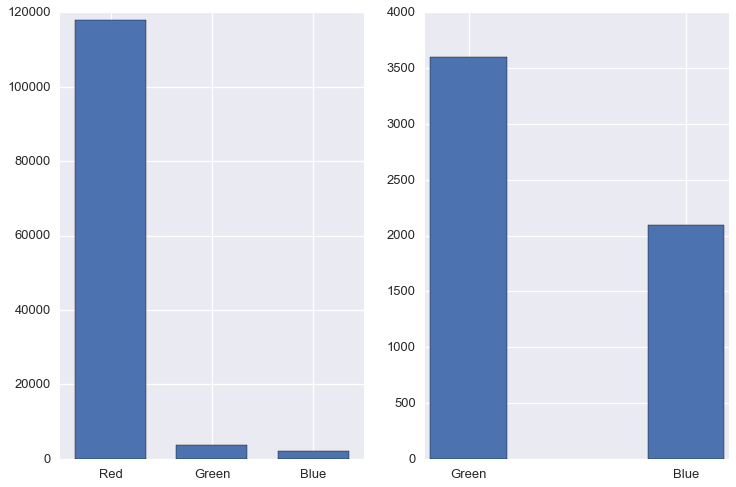

In [284]:
checkFeatures()

Same thing using the `f_oneway` function (1-way ANOVA):

*(NOTA: the list comprehension here is applied on a pandas `groupby` object, unpacked in the for loop, we get the*
*values k which are the groups values (here `0` and `1` respectively for non-skin and skin) and the value g which is*
*the DataFrame; we iterate through the columns we are interested in and we get a multidimensional array: for each*
*column, the first dimension is the group (k), the second dimension holds the related values)*

In [332]:
def performANOVA():
    for col in dt.columns[0:3]:
        f_stat = f_oneway(*[g[col] for k, g in dt.groupby('Skin')])
        print "{} => Statistic = {:<6.0f} / p-value = {:.2e}".format(col, f_stat.statistic, f_stat.pvalue)

performANOVA()

R => Statistic = 117910 / p-value = 0.00e+00
G => Statistic = 3600   / p-value = 0.00e+00
B => Statistic = 2093   / p-value = 0.00e+00


Looks like the `Red` color is by far the most powerful feature for classification. `Green` is way below but still almost twice as powerful as `Blue`.

We may drop the `Blue` feature. The question is, can we also drop the `Green` feature or is the `Red` feature enough to get accurate results?

One may argue that skin tones are within a particular range of reds and as soon as we are out of this range, we can say (with a reasonnable accuracy) this is no skin tone.

Let's try and compare.

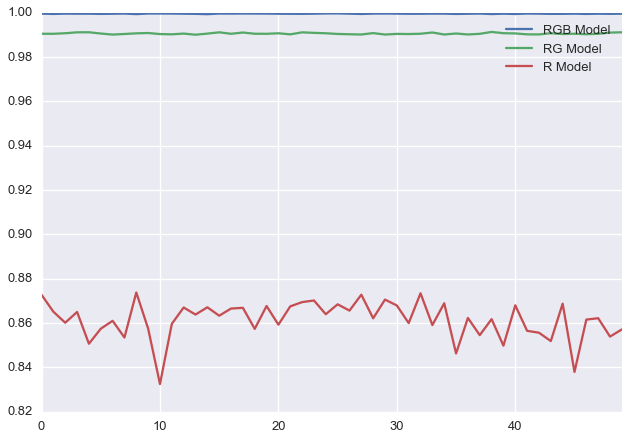

In [369]:
def compareModels():
    X_full = dt.ix[:, 'R':'B']
    X_smpl = dt.ix[:, 'R':'G']
    X_less = dt.ix[:, 'R']
    y = dt.ix[:, 'Skin']
    scores_full = list()
    scores_smpl = list()
    scores_less = list()
    for i in range(50):
        X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size = 0.3)
        X_train_smpl, X_test_smpl, y_train_smpl, y_test_smpl = train_test_split(X_smpl, y, test_size = 0.3)
        X_train_less, X_test_less, y_train_less, y_test_less = train_test_split(X_less.values.reshape(-1,1), y, test_size = 0.3)
        clf_full = KNN(3)
        clf_smpl = KNN(3)
        clf_less = KNN(3)
        clf_full.fit(X_train_full, y_train_full)
        clf_smpl.fit(X_train_smpl, y_train_smpl)
        clf_less.fit(X_train_less, y_train_less)
        scores_full.append(clf_full.score(X_test_full, y_test_full))
        scores_smpl.append(clf_smpl.score(X_test_smpl, y_test_smpl))
        scores_less.append(clf_less.score(X_test_less, y_test_less))
    pd.Series(scores_full).plot()
    pd.Series(scores_smpl).plot()
    pd.Series(scores_less).plot()
    plt.legend(('RGB Model', 'RG Model', 'R Model'))

compareModels()

Using only the red color may lead to a weaker and somewhat unstable model. Using all three features lead to a suspiciously efficient model. Using only red and green colors yield pretty good results.

Something we may try later:

* Use normalized values such as:

$$V_{inorm1} = \frac{V_i - mean_V}{std_V}$$

$$V_{inorm2} = \frac{V_i - min_V}{max_V - min_V}$$

* Try to give more weight to some features (for instance `Red`)
* Alternatively, try to reduce the weight of some other features (for instance `Blue`)

_(NOTA: the results may look like this because the `k` we choose was particularly well fitted for the `RGB` model, thus_
_leading to poorer accuracy with the other models; the cross-validation step my be rerun for both and see if we can_
_find a better `k`)_

#### Growing Trees

In [420]:
def crazyGardening():
    X_full = dt.ix[:, 'R':'B']
    X_smpl = dt.ix[:, 'R':'G']
    X_less = dt.ix[:, 'R':'R']
    y = dt.ix[:, 'Skin']
    
    X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size = 0.3)
    X_train_smpl, X_test_smpl, y_train_smpl, y_test_smpl = train_test_split(X_smpl, y, test_size = 0.3)
    X_train_less, X_test_less, y_train_less, y_test_less = train_test_split(X_less, y, test_size = 0.3)
    
    clf_tree_full = tree.DecisionTreeClassifier()
    clf_tree_full.fit(X_train_full, y_train_full)
    clf_tree_smpl = tree.DecisionTreeClassifier()
    clf_tree_smpl.fit(X_train_smpl, y_train_smpl)
    clf_tree_less = tree.DecisionTreeClassifier()
    clf_tree_less.fit(X_train_less.values.reshape(-1,1), y_train_less)
    
    pred_test_full = clf_tree_full.predict(X_test_full)
    precision_full, recall_full, thresholds_full = metrics.precision_recall_curve(y_test_full, pred_test_full)
    area_full = metrics.auc(recall_full, precision_full)
    pred_test_smpl = clf_tree_smpl.predict(X_test_smpl)
    precision_smpl, recall_smpl, thresholds_smpl = metrics.precision_recall_curve(y_test_smpl, pred_test_smpl)
    area_smpl = metrics.auc(recall_smpl, precision_smpl)
    pred_test_less = clf_tree_less.predict(X_test_less)
    precision_less, recall_less, thresholds_less = metrics.precision_recall_curve(y_test_less, pred_test_less)
    area_less = metrics.auc(recall_less, precision_less)
    
    print('Scores: RGB = {:.3f} | RG  = {:.3f} | R   = {:.3f}'.format(clf_tree_full.score(X_test_full, y_test_full),
                                                                     clf_tree_smpl.score(X_test_smpl, y_test_smpl),
                                                                     clf_tree_less.score(X_test_less, y_test_less)))
    print('RGB Model: score = {:.3f} ' \
          '|| 0-skin right {:<5} | 0-skin wrong {:<5} ' \
          '|| 1-skin right {:<5} ' \
          '| 1-skin wrong {:<5}'.format(clf_tree_full.score(X_test_full, y_test_full),
                                           metrics.confusion_matrix(y_test_full, pred_test_full)[0][0],
                                           metrics.confusion_matrix(y_test_full, pred_test_full)[0][1],
                                           metrics.confusion_matrix(y_test_full, pred_test_full)[1][1],
                                           metrics.confusion_matrix(y_test_full, pred_test_full)[1][0]))
    
    print('RG  Model: score = {:.3f} ' \
          '|| 0-skin right {:<5} | 0-skin wrong {:<5} ' \
          '|| 1-skin right {:<5} ' \
          '| 1-skin wrong {:<5}'.format(clf_tree_smpl.score(X_test_smpl, y_test_smpl),
                                           metrics.confusion_matrix(y_test_smpl, pred_test_smpl)[0][0],
                                           metrics.confusion_matrix(y_test_smpl, pred_test_smpl)[0][1],
                                           metrics.confusion_matrix(y_test_smpl, pred_test_smpl)[1][1],
                                           metrics.confusion_matrix(y_test_smpl, pred_test_smpl)[1][0]))
    
    print('R   Model: score = {:.3f} ' \
          '|| 0-skin right {:<5} | 0-skin wrong {:<5} ' \
          '|| 1-skin right {:<5} ' \
          '| 1-skin wrong {:<5}'.format(clf_tree_less.score(X_test_less, y_test_less),
                                           metrics.confusion_matrix(y_test_less, pred_test_less)[0][0],
                                           metrics.confusion_matrix(y_test_less, pred_test_less)[0][1],
                                           metrics.confusion_matrix(y_test_less, pred_test_less)[1][1],
                                           metrics.confusion_matrix(y_test_less, pred_test_less)[1][0]))
    
    print(metrics.classification_report(y_test_full, pred_test_full))
    print(metrics.classification_report(y_test_smpl, pred_test_smpl))
    print(metrics.classification_report(y_test_less, pred_test_less))

    plt.figure(1, figsize = (12, 8))
    plt.plot(recall_full, precision_full, label = 'Precision-Recall RGB Model')
    plt.plot(recall_smpl, precision_smpl, label = 'Precision-Recall RG  Model')
    plt.plot(recall_less, precision_less, label = 'Precision-Recall R   Model')
    plt.legend(('RGB | AUC = {:.3f}'.format(area_full),
                'RG  | AUC = {:.3f}'.format(area_smpl), 
                'R   | AUC = {:.3f}'.format(area_less)), loc = 'lower left')

Scores: RGB = 0.999 | RG  = 0.990 | R   = 0.887
RGB Model: score = 0.999 || 0-skin right 58169 | 0-skin wrong 28    || 1-skin right 15300 | 1-skin wrong 21   
RG  Model: score = 0.990 || 0-skin right 57821 | 0-skin wrong 465   || 1-skin right 14963 | 1-skin wrong 269  
R   Model: score = 0.887 || 0-skin right 54394 | 0-skin wrong 3858  || 1-skin right 10852 | 1-skin wrong 4414 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     58197
          1       1.00      1.00      1.00     15321

avg / total       1.00      1.00      1.00     73518

             precision    recall  f1-score   support

          0       1.00      0.99      0.99     58286
          1       0.97      0.98      0.98     15232

avg / total       0.99      0.99      0.99     73518

             precision    recall  f1-score   support

          0       0.92      0.93      0.93     58252
          1       0.74      0.71      0.72     15266

avg / total       0.89      

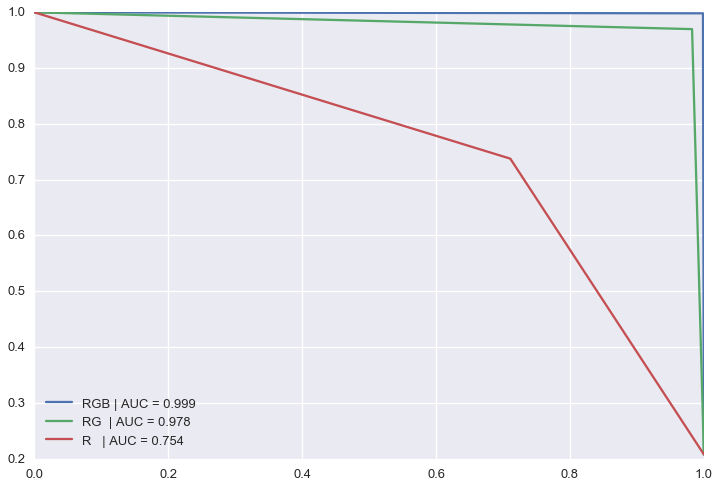

In [421]:
crazyGardening()

In [444]:
def intermediateGardening(features = 'RGB', leaves = 1):
    feats = list(features)
    X = dt.ix[:, feats]
    y = dt.ix[:, 'Skin']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12)
    plt.figure(1, figsize = (12, 15))
    for j in np.arange(1, 11):
        clf_tree = tree.DecisionTreeClassifier()
        clf_tree.set_params(max_depth = j, min_samples_leaf = leaves)
        if len(feats) == 1:
            clf_tree.fit(X_train.values.reshape(-1,1), y_train)
        else:
            clf_tree.fit(X_train, y_train)
        #conf = metrics.confusion_matrix(y_test, clf_tree.predict(X_test))
        precision, recall, thresholds = metrics.precision_recall_curve(y_test, clf_tree.predict(X_test))
        plt.plot(recall, precision, label = 'max-depth {:0>2} | min-leaf {:0>2}'.format(j, leaves))
    plt.title('{:<3} Model: Precision-Recall Curve for Different Parameters'.format(features))
    plt.legend(loc = 'lower left');

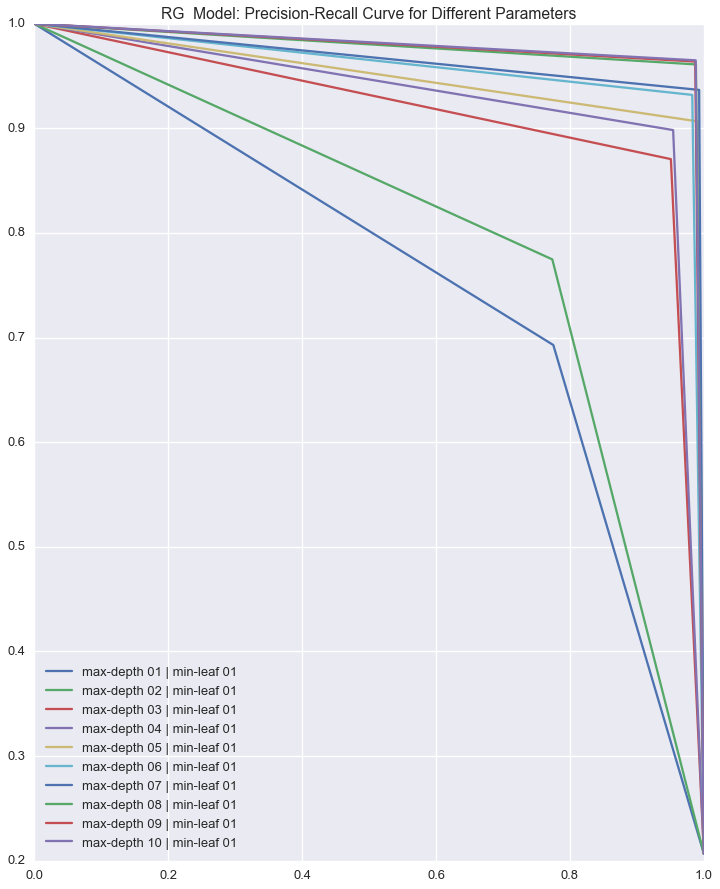

In [445]:
interact(intermediateGardening, leaves = (1, 10, 1), features = ['RGB', 'RG', 'R']);

In [448]:
def intermediateGardeningWithText(features = 'RGB', leaves = 1):
    feats = list(features)
    X = dt.ix[:, feats]
    y = dt.ix[:, 'Skin']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12)
    for j in np.arange(1, 11):
        clf_tree = tree.DecisionTreeClassifier()
        clf_tree.set_params(max_depth = j, min_samples_leaf = leaves)
        if len(feats) == 1:
            clf_tree.fit(X_train.values.reshape(-1,1), y_train)
        else:
            clf_tree.fit(X_train, y_train)
        conf = metrics.confusion_matrix(y_test, clf_tree.predict(X_test))
        print('{:<3} Model {}D{}L : score = {:.3f} ' \
              '|| 0-skin right {:<5} | 0-skin wrong {:<5} || 1-skin right {:<5} ' \
              '| 1-skin wrong {:<5}'.format(features, j, leaves, clf_tree.score(X_test, y_test), 
                                            conf[0][0],
                                            conf[0][1],
                                            conf[1][1],
                                            conf[1][0]))

In [450]:
interact(intermediateGardeningWithText, features = ['RGB', 'RG', 'B'], leaves = (1, 10, 1));

B   Model 1D1L : score = 0.793 || 0-skin right 58328 | 0-skin wrong 0     || 1-skin right 0     | 1-skin wrong 15190
B   Model 2D1L : score = 0.793 || 0-skin right 58328 | 0-skin wrong 0     || 1-skin right 0     | 1-skin wrong 15190
B   Model 3D1L : score = 0.793 || 0-skin right 58328 | 0-skin wrong 0     || 1-skin right 0     | 1-skin wrong 15190
B   Model 4D1L : score = 0.793 || 0-skin right 58328 | 0-skin wrong 0     || 1-skin right 0     | 1-skin wrong 15190
B   Model 5D1L : score = 0.795 || 0-skin right 54211 | 0-skin wrong 4117  || 1-skin right 4225  | 1-skin wrong 10965
B   Model 6D1L : score = 0.795 || 0-skin right 54211 | 0-skin wrong 4117  || 1-skin right 4225  | 1-skin wrong 10965
B   Model 7D1L : score = 0.799 || 0-skin right 56060 | 0-skin wrong 2268  || 1-skin right 2685  | 1-skin wrong 12505
B   Model 8D1L : score = 0.800 || 0-skin right 56398 | 0-skin wrong 1930  || 1-skin right 2429  | 1-skin wrong 12761
B   Model 9D1L : score = 0.799 || 0-skin right 55815 | 0-skin wr